# Data Analysis

## Import

In [1]:
import pandas as pd # For handling and analyzing tabular data

# For visualization
import seaborn as sns
import matplotlib.pyplot as plt

import re # For validating and manipulating text
import numpy as np # For numeric calculation

## Read cleaned data from CSV file

In [2]:
anime_data = pd.read_csv('./data/anime_data_cleaned.csv')

# Check dataset
anime_data

,ID,Title,Alternative Title (en),Media Type,Status,Premiered Season,Genres,User Score,Number of Ratings,Number of Members,Studios,Rating
0,2471,Doraemon (1979),Doraemon,tv,finished_airing,Spring 1979,"Adventure, Anthropomorphic, Comedy, Fantasy, K...",7.86,39342,66089,Shin-Ei Animation,pg
1,813,Dragon Ball Z,Dragon Ball Z,tv,finished_airing,Spring 1989,"Action, Adventure, Comedy, Fantasy, Martial Ar...",8.19,863786,1258233,Toei Animation,pg_13
2,966,Crayon Shin-chan,Shin Chan,tv,currently_airing,Spring 1992,"Comedy, Ecchi, School, Seinen",7.80,41800,87019,Shin-Ei Animation,g
3,170,Slam Dunk,Slam Dunk,tv,finished_airing,Fall 1993,"School, Shounen, Sports, Team Sports",8.55,141218,312658,Toei Animation,pg_13
4,103,Akazukin Chacha,Red Riding Hood Chacha,tv,finished_airing,Winter 1994,"Adventure, Comedy, Fantasy, Mahou Shoujo, Roma...",7.41,6075,16889,Gallop,g
...,...,...,...,...,...,...,...,...,...,...,...,...
2145,56228,Rekishi ni Nokoru Akujo ni Naru zo,I'll Become a Villainess Who Goes Down in History,tv,currently_airing,Fall 2024,"Comedy, Fantasy, Isekai, Romance, Shoujo, Vill...",7.06,8835,61849,Maho Film,pg_13
2146,57102,Houkago Shounen Hanako-kun Part 2,After-School Hanako-kun Part 2,tv,finished_airing,Fall 2024,"Comedy, School, Supernatural",7.02,5245,29133,Lerche,pg_13
2147,54726,"Tsuma, Shougakusei ni Naru.",TsumaSho,tv,currently_airing,Fall 2024,"Comedy, Reincarnation, Romance, Seinen",7.23,5155,41356,Studio Signpost,pg_13
2148,53033,Mecha-ude (TV),Mecha-Ude: Mechanical Arms,tv,currently_airing,Fall 2024,"Action, Sci-Fi",7.07,5015,39806,TriF Studio,pg_13


## Question 01: Which anime genres have been the most or least popular among viewers over the years?

### Brief explanation
- Identify the most popular anime genres among viewers by analyzing their preferences over the years (starting from 1995).
- We only focus on our included genres (e.g., action, drama, comedy, etc.).

### Benefits of finding answer
- **Understand audience preferences**: Helps producers and marketers tailor their future projects to align with popular genres.
- **Improve recommendations**: Some anime streaming platforms can use this data to suggest anime based on trending genres, which **will be very helpful for beginners watching anime to choose hot-trend genres that are suitable for them**.
- **Market insights**: Useful for identifying trends in the anime industry and predicting future shifts in viewer preferences.

### Find the answer by using data
- We will use the ```Genres``` column along with the mean (average) of ```Number of Members``` metric to measure genre popularity.
- We only focus on our included genres.
- Visualize the answer and draw conclusions.

In [3]:
# Included genres list
included_genres = [
    'action', 'adventure', 'comedy', 'drama', 'fantasy',
    'mystery', 'romance', 'sci-fi', 'slice of life', 'sports'
]

In [4]:
# Expand the Genres column and focus on included genres
genre_popularity = (
    anime_data[['Genres', 'Number of Members']]
    .assign(Genres=anime_data['Genres'].str.split(', '))
    .explode('Genres')  # Split and expand genres into separate rows
    .query('Genres.str.lower() in @included_genres', engine='python')  # Filter included genres
    .groupby('Genres')['Number of Members']  # Group by genres
    .mean()  # Aggregate by the mean of Number of Members -> Popularity
    .sort_values(ascending=False)  # Sort by popularity
)

# Reset index to prepare for visualization
genre_popularity = (
    genre_popularity
    .rename_axis('Genre')
    .reset_index()
    .round({'Number of Members': 0}) # Round to 0 decimal places
)

genre_popularity

,Genre,Number of Members
0,Action,354086.0
1,Fantasy,325714.0
2,Drama,317777.0
3,Romance,304284.0
4,Mystery,287439.0
5,Adventure,282919.0
6,Comedy,241836.0
7,Sci-Fi,215773.0
8,Sports,196190.0
9,Slice of Life,165812.0


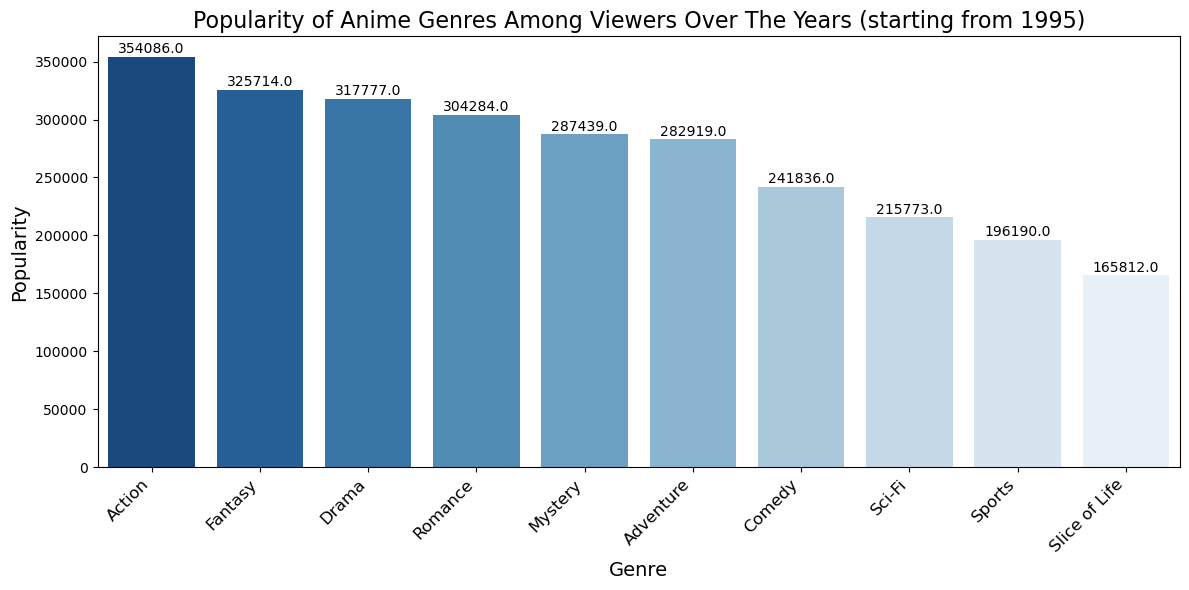

In [5]:
# Visualize (vertical bar chart)
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(
    x='Genre',
    y='Number of Members',
    data=genre_popularity,
    palette='Blues_r',
    hue='Genre',
    legend=False
)

# Add specific values on top of each bar
for index, row in genre_popularity.iterrows():
    bar_plot.text(
        x=index,
        y=row['Number of Members'] + 3000,  # Position above the bar
        s=f"{row['Number of Members']}",
        ha='center',
        fontsize=10,
        color='black'
    )
    
plt.title("Popularity of Anime Genres Among Viewers Over The Years (starting from 1995)", fontsize=16)
plt.xlabel("Genre", fontsize=14)
plt.ylabel("Popularity", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()

plt.show()

### Conclusions

- The most popular genre over the years is **Action** (~354086).
- The least popular genre over the years is **Slice of Life** (~165811).

## Question 02: Which anime genres have received the most or least positive reviews from viewers over the years?

### Brief explanation
- Determine which genres tend to elicit the most extreme reactions from viewers over the years (starting from 1995) by analyzing ```User Score``` column.
- We only focus on our included genres (e.g., action, drama, comedy, etc.).

### Benefits of finding answer
- **Identify strengths and weaknesses**: Understanding which genres perform well or poorly helps producers and platforms refine their offerings.
- **Improve recommendations**: Platforms can prioritize promoting highly-rated genres to attract and retain viewers, which **will be very helpful for beginners watching anime to choose good genres that are suitable for them**.
- **Measure genre appeal**: Helps determine viewer preferences and guide future investments in anime production for specific genres.

### Find the answer by using data
- We will use the ```Genres``` column along with the mean (average) of ```User Score``` metric to measure genre popularity.
- We only focus on our included genres.
- Visualize the answer and draw conclusions.

In [6]:
# Expand the Genres column and focus on included genres
genre_scores = (
    anime_data[['Genres', 'User Score']]
    .assign(Genres=anime_data['Genres'].str.split(', '))
    .explode('Genres')  # Split and expand genres into separate rows
    .query('Genres.str.lower() in @included_genres', engine='python')  # Filter included genres
    .groupby('Genres')['User Score']  # Group by genres
    .mean()  # Aggregate by the mean of User Score
    .sort_values(ascending=False)  # Sort by User Score
)

# Reset index to prepare for visualization
genre_scores = (
    genre_scores
    .rename_axis('Genre')
    .reset_index()
    .rename(columns={'User Score': 'Average User Score'})  # Rename 'User Score' column
    .round({'Average User Score': 2})  # Round to 2 decimal places
)

genre_scores

,Genre,Average User Score
0,Sports,7.70
1,Mystery,7.69
2,Slice of Life,7.69
3,Drama,7.66
4,Action,7.55
5,Adventure,7.50
6,Romance,7.49
7,Fantasy,7.47
8,Comedy,7.47
9,Sci-Fi,7.46


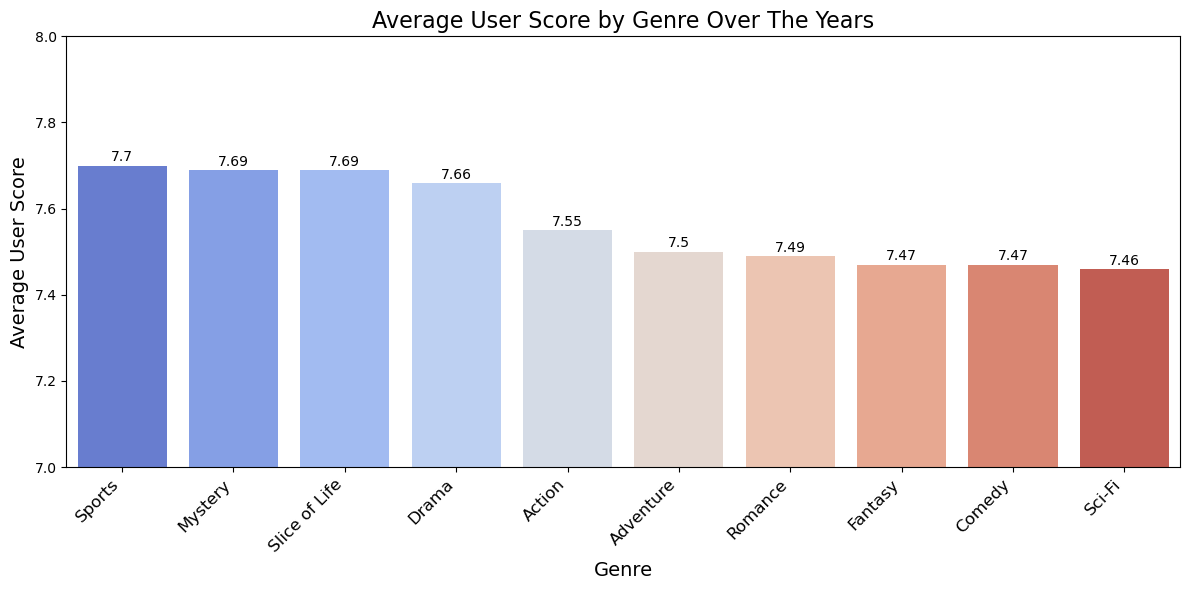

In [7]:
# Visualize (vertical bar chart)
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(
    x='Genre',
    y='Average User Score',
    data=genre_scores,
    palette='coolwarm',
    hue='Genre',
    legend=False
)

# Adjust Y-axis range to emphasize differences
plt.ylim(7, 8)  # Focus on the range of values

# Add specific values on top of each bar
for index, row in genre_scores.iterrows():
    bar_plot.text(
        x=index,
        y=row['Average User Score'] + 0.01,  # Position above the bar
        s=f"{row['Average User Score']}",
        ha='center',
        fontsize=10,
        color='black'
    )

plt.title("Average User Score by Genre Over The Years", fontsize=16)
plt.xlabel("Genre", fontsize=14)
plt.ylabel("Average User Score", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

### Conclusions

- Viewer ratings for anime genres over the years have consistently been **quite good** (~7.5).
- The highest-rated anime genre by viewers over the years is **Sports** (~7.7).
- The lowest-rated anime genre by viewers over the years is **Sci-Fi** (~7.46).